In [68]:
from sklearn.datasets import fetch_california_housing

data=fetch_california_housing(as_frame=True)

df = data['frame']

In [69]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)


In [146]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_train, title='Boston Housing', explorative=True)


In [147]:
profile.to_widgets()

In [72]:
df_train.describe(include='all')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,3.876892,28.575374,5.438125,1.098033,1427.927326,3.119236,35.650669,-119.584102,2.069240
std,1.904908,12.613634,2.453569,0.447498,1140.225190,12.373636,2.135742,2.002930,1.157492
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000,0.149990
25%,2.567225,18.000000,4.448928,1.006783,791.000000,2.430380,33.940000,-121.800000,1.193000
50%,3.539100,29.000000,5.232422,1.049492,1168.000000,2.817147,34.270000,-118.510000,1.793000
75%,4.758075,37.000000,6.060692,1.100328,1727.000000,3.279135,37.720000,-118.010000,2.646000
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000,5.000010


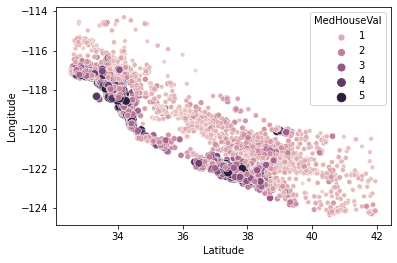

In [286]:
import seaborn as sns

sns.scatterplot(data=df_train, x="Latitude", y="Longitude",hue='MedHouseVal', size='MedHouseVal')


In [267]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)

In [268]:
def get_xy(df):
    return df.drop(['MedHouseVal'], 1), df['MedHouseVal']

X_train, y_train = get_xy(df_train)
X_test, y_test = get_xy(df_test
                       )

In [269]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [270]:
from sklearn.metrics import mean_squared_error
y_pred = dt.predict(X_test)


mean_squared_error(y_test, y_pred)

0.5243902731727552

In [271]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('clf', dt)])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
mean_squared_error(y_test, y_pred)

0.5243902731727552

In [272]:
from sklearn.preprocessing import StandardScaler

In [273]:
pipe_with_preprocess = Pipeline([('scaler', StandardScaler()), ('clf', dt)])
pipe_with_preprocess.fit(X_train, y_train)

y_pred = pipe_with_preprocess.predict(X_test)
mean_squared_error(y_test, y_pred)

0.5231860400719638

In [274]:
class ZScoreCAHousing:
    
    def __init__(self):
        self.mean = 0
        self.std = 0
    
    def fit(self, X, y=None):
        self.mean = X.mean()
        self.std = X.std()
        return self
    
    def transform(self, X, y=None):
        return (X - self.mean) / self.std
        

In [275]:
p = ZScoreCAHousing()

In [276]:
pipe_with_custom_zscore_preprocess = Pipeline([('scaler', ZScoreCAHousing()), ('clf', dt)])
pipe_with_custom_zscore_preprocess.fit(X_train, y_train)

y_pred = pipe_with_custom_zscore_preprocess.predict(X_test)
mean_squared_error(y_test, y_pred)

0.5235583038026002

/Users/lneves/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


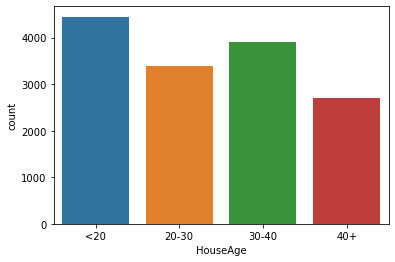

In [277]:
import math
import seaborn as sns

bins = pd.cut(X_train['HouseAge'], bins=[0, 20, 30, 40, 100],
                              labels=['<20', '20-30', '30-40', '40+'])

sns.countplot(bins)

In [312]:
import math
import numpy as np
class PreprocessHousing:
    
    def __init__(self, feats_to_log=['MedInc', 'Population'], 
                                     feats_to_zscore=['MedInc', 'Population']):
        self.mean = {}
        self.std = {}
        self.feats_to_log = feats_to_log
        self.feats_to_zscore = feats_to_zscore
    
    def fit(self, X, y=None):
        """
        Existing features
        MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude
        """
        X = X.copy()
        for feat in self.feats_to_log: # apply log transform
            X[feat] = X[feat].apply(math.log)
        
        
        for feat in self.feats_to_zscore:
            self.mean[feat] = X[feat].mean()
            self.std[feat] = X[feat].std()
        
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['HouseAge'] = pd.cut(X['HouseAge'], bins=[0, 20, 30, 40, 100],labels=list(range(4))) #['<20', '20-30', '30-40', '40+']
        
        
        def haversine_distance(lat, long):

            # based on from https://en.wikipedia.org/wiki/Haversine_formula
            ocean_lat = 34
            ocean_long = -122
            radius = 6371 # km

            rad_lat = np.radians(ocean_lat - lat)
            rad_long = np.radians(ocean_long - long)
            a = np.sin(rad_lat/2) * np.sin(rad_lat/2) + np.cos(np.radians(lat)) * np.cos(np.radians(ocean_lat)) * np.sin(rad_long/2) * np.sin(rad_long/2)
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            distance = radius * c

            return distance
        
        X['distance_to_ocean'] = X.apply(lambda x: haversine_distance(x.Latitude, x.Longitude), axis=1)
        
        for feat in self.feats_to_log: # apply log transform
            X[feat] = X[feat].apply(math.log)
                               
        for feat in self.feats_to_zscore:
            X[feat] = (X[feat] - self.mean[feat]) / self.std[feat]
            
        return X

In [313]:
ph = PreprocessHousing()
pipe_with_custom_preprocess = Pipeline([('preprocess', PreprocessHousing()), ('clf', dt)])
pipe_with_custom_preprocess.fit(X_train, y_train)

y_pred = pipe_with_custom_preprocess.predict(X_test)
mean_squared_error(y_test, y_pred)

0.4826583951654393

In [311]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
pipe_with_custom_preprocess_rf = Pipeline([('preprocess', PreprocessHousing()), ('clf', rf)])
pipe_with_custom_preprocess_rf.fit(X_train, y_train)

y_pred = pipe_with_custom_preprocess_rf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.24393230628796006